In [1]:
import torch
import torchvision 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
from sklearn.preprocessing import MinMaxScaler

In [1]:
import torch

print(torch.cuda.is_available())

print(torch.cuda.device_count())

(torch.cuda.current_device())

print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 2080 Ti


In [2]:
class BrainScanDataset(Dataset):
    def __init__(self, file_paths, transform=None, deterministic=False):
        self.file_paths = file_paths
        self.transform = transform
        if deterministic:  # To always generate the same test images for consistency
            np.random.seed(1)
        np.random.shuffle(self.file_paths)
        self.scaler = MinMaxScaler()
        
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        # Load h5 file, get image and mask
        file_path = self.file_paths[idx]
        with h5py.File(file_path, 'r') as file:
            image = file['image'][()]
            mask = file['mask'][()]
            
            # Reshape: (H, W, C) -> (C, H, W)
            image = image.transpose((2, 0, 1))
            mask = mask.transpose((2, 0, 1))
            
            # Adjusting pixel values for each channel in the image so they are between 0 and 255
            for i in range(image.shape[0]):    # Iterate over channels
                image[i] = self.scaler.fit_transform(image[i])
            
            # Convert to float and scale the whole image
            image = torch.tensor(image, dtype=torch.float32)
            mask = torch.tensor(mask, dtype=torch.float32) 
            
            # Apply transformations
            if self.transform:
                image = self.transform(image)
                mask = self.transform(mask)
            
        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
])

# Directory containing .h5 files
dir = "./BRaTS2020/BraTS2020_training_data/content/data"

# Build .h5 file paths from directory containing .h5 files
h5 = sorted([f for f in os.listdir(dir) if f.endswith('.h5')])
print(f"Found {len(h5)} .h5 files:\nExample file names:{h5[:5]}")

# Open the first .h5 file in the list to inspect its contents
print("\nContents of .h5 file")
if h5:
    file_path = os.path.join(dir, h5[25070])
    with h5py.File(file_path, 'r') as file:
        print("\nKeys for each file:", list(file.keys()))
        for key in file.keys():
            print(f"\nData type of {key}:", type(file[key][()]))
            print(f"Shape of {key}:", file[key].shape)
            print(f"Array dtype: {file[key].dtype}")
            print(f"Array max val: {np.max(file[key])}")
            print(f"Array min val: {np.min(file[key])}")
else:
    print("No .h5 files found in the directory.")

h5_files = [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.h5')]
np.random.seed(42)
np.random.shuffle(h5_files)

# Split the dataset into train and validation sets (90:10)
split_idx = int(0.8*len(h5_files))
train_files = h5_files[:split_idx]
val_files = h5_files[split_idx:-1]

# Create the train and val datasets with transformations
train_dataset = BrainScanDataset(train_files, transform=transform)
val_dataset = BrainScanDataset(val_files, transform=transform, deterministic=True)

# Sample dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Use this to generate test images to view later
test_input_iterator = iter(DataLoader(val_dataset, batch_size=1, shuffle=False))

# Verifying dataloaders work
for images, masks in train_dataloader:
    print("\nTraining batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break
for images, masks in val_dataloader:
    print("Validation batch - Images shape:", images.shape, "Masks shape:", masks.shape)
    break


Found 57195 .h5 files:
Example file names:['volume_100_slice_0.h5', 'volume_100_slice_1.h5', 'volume_100_slice_10.h5', 'volume_100_slice_100.h5', 'volume_100_slice_101.h5']

Contents of .h5 file

Keys for each file: ['image', 'mask']

Data type of image: <class 'numpy.ndarray'>
Shape of image: (240, 240, 4)
Array dtype: float64
Array max val: 4.755863264388587
Array min val: -0.5070322108800785

Data type of mask: <class 'numpy.ndarray'>
Shape of mask: (240, 240, 3)
Array dtype: uint8
Array max val: 1
Array min val: 0

Training batch - Images shape: torch.Size([16, 4, 240, 240]) Masks shape: torch.Size([16, 3, 240, 240])
Validation batch - Images shape: torch.Size([16, 4, 240, 240]) Masks shape: torch.Size([16, 3, 240, 240])


In [3]:
# Check if GPU is available
if torch.cuda.is_available():
    # Get the name of the first GPU
    print(torch.cuda.get_device_name(0))

NVIDIA GeForce GTX 1080 Ti


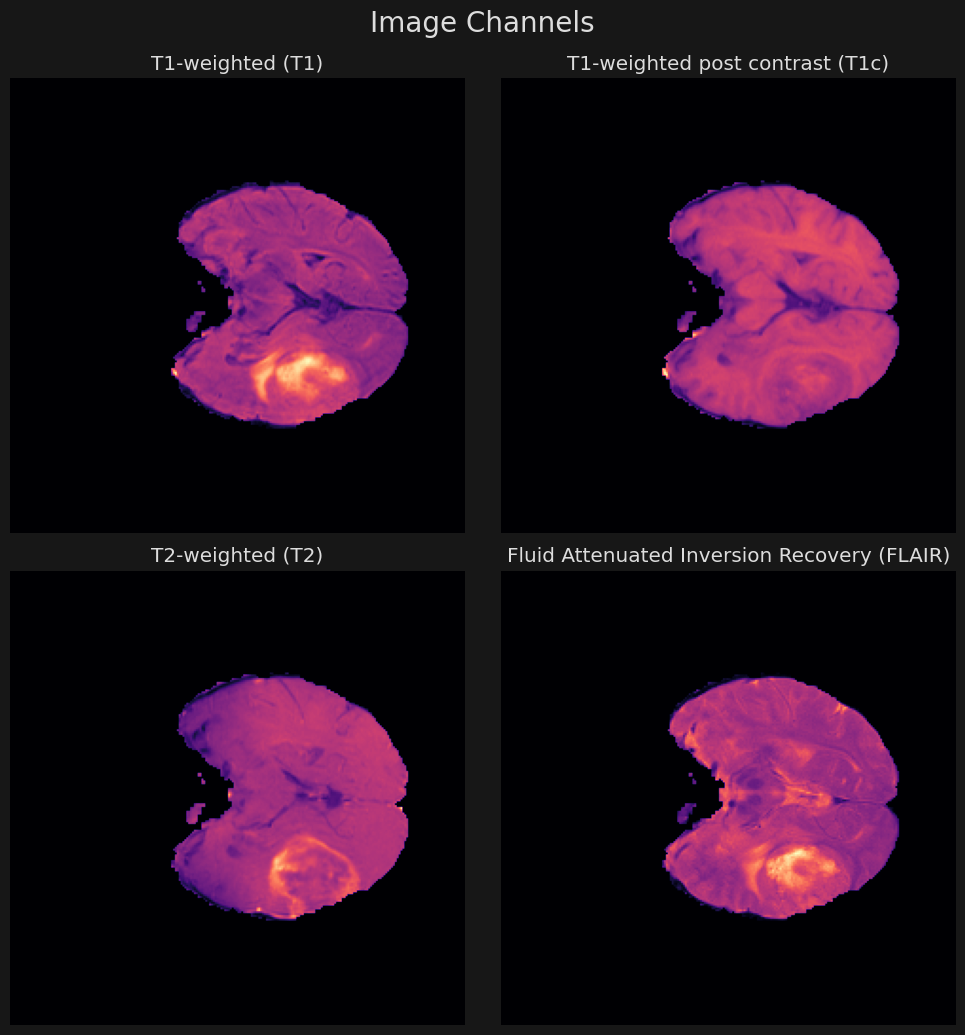

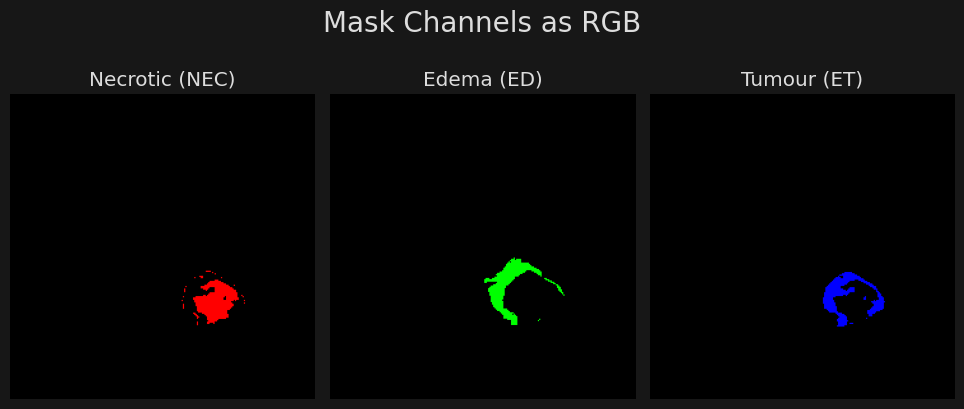

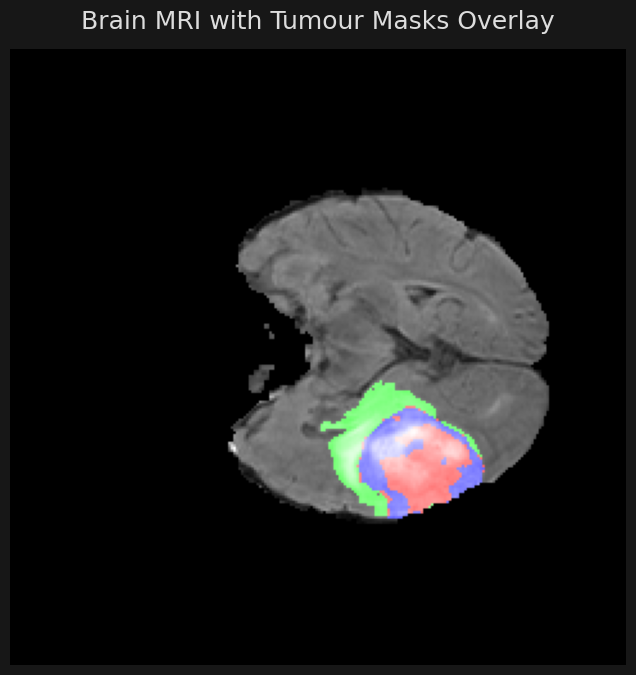

In [4]:
plt.style.use('ggplot')
plt.rcParams['figure.facecolor'] = '#171717'
plt.rcParams['text.color']       = '#DDDDDD'

def display_image_channels(image, title='Image Channels'):
    channel_names = ['T1-weighted (T1)', 'T1-weighted post contrast (T1c)', 'T2-weighted (T2)', 'Fluid Attenuated Inversion Recovery (FLAIR)']
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    for idx, ax in enumerate(axes.flatten()):
        channel_image = image[idx, :, :]  # Transpose the array to display the channel
        ax.imshow(channel_image, cmap='magma')
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.tight_layout()
    plt.suptitle(title, fontsize=20, y=1.03)
    plt.show()

def display_mask_channels_as_rgb(mask, title='Mask Channels as RGB'):
    channel_names = ['Necrotic (NEC)', 'Edema (ED)', 'Tumour (ET)']
    fig, axes = plt.subplots(1, 3, figsize=(9.75, 5))
    for idx, ax in enumerate(axes):
        rgb_mask = np.zeros((mask.shape[1], mask.shape[2], 3), dtype=np.uint8)
        rgb_mask[..., idx] = mask[idx, :, :] * 255  # Transpose the array to display the channel
        ax.imshow(rgb_mask)
        ax.axis('off')
        ax.set_title(channel_names[idx])
    plt.suptitle(title, fontsize=20, y=0.93)
    plt.tight_layout()
    plt.show()

def overlay_masks_on_image(image, mask, title='Brain MRI with Tumour Masks Overlay'):
    t1_image = image[0, :, :]  # Use the first channel of the image
    t1_image_normalized = (t1_image - t1_image.min()) / (t1_image.max() - t1_image.min())

    rgb_image = np.stack([t1_image_normalized] * 3, axis=-1)
    color_mask = np.stack([mask[0, :, :], mask[1, :, :], mask[2, :, :]], axis=-1)
    rgb_image = np.where(color_mask, color_mask, rgb_image)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_image)
    plt.title(title, fontsize=18, y=1.02)
    plt.axis('off')
    plt.show()
    
    
# Sample image to view
sample_file_path = os.path.join(dir, h5[25070])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

# Transpose the image and mask to have channels first
image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)

# View images using plotting functions
display_image_channels(image)
display_mask_channels_as_rgb(mask)
overlay_masks_on_image(image, mask)

In [5]:
sample_file_path

'./BRaTS2020/BraTS2020_training_data/content/data/volume_246_slice_63.h5'

In [6]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5, ignore_index=None):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index

    def forward(self, inputs, targets):
        # Comment out if your model contains a sigmoid or block to normalize the final output
        inputs = F.sigmoid(inputs)

        # Flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        # Remove indices from inputs and targets that correspond to the ignore_index value
        if self.ignore_index is not None:
            valid_indices = (targets != self.ignore_index).nonzero().squeeze()
            inputs = inputs[valid_indices]
            targets = targets[valid_indices]

        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)

        return 1 - dice_coeff

class Squeeze_Excitation(nn.Module):
    def __init__(self, channel, r=8):
        super().__init__()

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.net = nn.Sequential(
            nn.Linear(channel, channel // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // r, channel, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, inputs):
        b, c, _, _ = inputs.shape
        x = self.pool(inputs).view(b, c)
        x = self.net(x).view(b, c, 1, 1)
        x = inputs * x
        return x

class Stem_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ResNet_Block(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.ReLU(),
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride),
            nn.BatchNorm2d(out_c),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, padding=0),
            nn.BatchNorm2d(out_c),
        )

        self.attn = Squeeze_Excitation(out_c)

    def forward(self, inputs):
        x = self.c1(inputs)
        s = self.c2(inputs)
        y = self.attn(x + s)
        return y

class ASPP(nn.Module):
    def __init__(self, in_c, out_c, rate=[1, 6, 12, 18]):
        super().__init__()

        self.c1 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[0], padding=rate[0]),
            nn.BatchNorm2d(out_c)
        )

        self.c2 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[1], padding=rate[1]),
            nn.BatchNorm2d(out_c)
        )

        self.c3 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[2], padding=rate[2]),
            nn.BatchNorm2d(out_c)
        )

        self.c4 = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, dilation=rate[3], padding=rate[3]),
            nn.BatchNorm2d(out_c)
        )

        self.c5 = nn.Conv2d(out_c, out_c, kernel_size=1, padding=0)


    def forward(self, inputs):
        x1 = self.c1(inputs)
        x2 = self.c2(inputs)
        x3 = self.c3(inputs)
        x4 = self.c4(inputs)
        x = x1 + x2 + x3 + x4
        y = self.c5(x)
        return y

class Attention_Block(nn.Module):
    def __init__(self, in_c):
        super().__init__()
        out_c = in_c[1]

        self.g_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[0]),
            nn.ReLU(),
            nn.Conv2d(in_c[0], out_c, kernel_size=3, padding=1),
            nn.MaxPool2d((2, 2))
        )

        self.x_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(in_c[1], out_c, kernel_size=3, padding=1),
        )

        self.gc_conv = nn.Sequential(
            nn.BatchNorm2d(in_c[1]),
            nn.ReLU(),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
        )

    def forward(self, g, x):
        g_pool = self.g_conv(g)
        x_conv = self.x_conv(x)
        gc_sum = g_pool + x_conv
        gc_conv = self.gc_conv(gc_sum)
        y = gc_conv * x
        return y

class Decoder_Block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()

        self.a1 = Attention_Block(in_c)
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.r1 = ResNet_Block(in_c[0]+in_c[1], out_c, stride=1)

    def forward(self, g, x):
        d = self.a1(g, x)
        d = self.up(d)
        d = torch.cat([d, g], axis=1)
        d = self.r1(d)
        return d

class build_resunetplusplus(nn.Module):
    def __init__(self):
        super().__init__()

        self.c1 = Stem_Block(4, 16, stride=1)
        self.c2 = ResNet_Block(16, 32, stride=2)
        self.c3 = ResNet_Block(32, 64, stride=2)
        self.c4 = ResNet_Block(64, 128, stride=2)

        self.b1 = ASPP(128, 256)

        self.d1 = Decoder_Block([64, 256], 128)
        self.d2 = Decoder_Block([32, 128], 64)
        self.d3 = Decoder_Block([16, 64], 32)

        self.aspp = ASPP(32, 16)
        self.output = nn.Conv2d(16, 3, kernel_size=1, padding=0)

    def forward(self, inputs):
        c1 = self.c1(inputs)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        c4 = self.c4(c3)

        b1 = self.b1(c4)

        d1 = self.d1(c3, b1)
        d2 = self.d2(c2, d1)
        d3 = self.d3(c1, d2)

        output = self.aspp(d3)
        output = self.output(output)

        return output

In [7]:
#hyp
# Function to count number of parameters in a model for comparisons later
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total Parameters: {total_params:,}\n')

# Function that saves a model to specified path
def save_model(model, path='Resunet++_brain_segmentation_lr-0.0001_all_batches.pth'):
    torch.save(model.state_dict(), path)

def train_model(model, train_dataloader, val_dataloader, config):
    device = config['device']
    n_epochs = config['n_epochs']
    learning_rate = config['learning_rate']
    batches_per_epoch = config['batches_per_epoch']
    lr_decay_factor = config['lr_decay_factor']

    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_fn = DiceLoss()

    train_epoch_losses = []
    val_epoch_losses = []
    
    print("Training...")
    for epoch in range(1, n_epochs + 1):
        # Decay learning rate
        current_lr = learning_rate
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_lr

        # Training step
        model.train()
        train_epoch_loss = 0
        for train_batch_idx, (train_inputs, train_targets) in enumerate(train_dataloader, start=1):
            print(f"\rTrain batch: {train_batch_idx}/{batches_per_epoch}, Avg batch loss: {train_epoch_loss/train_batch_idx:.6f}", end='')
            train_inputs = train_inputs.to(device)
            train_targets = train_targets.to(device)
            train_preds = model(train_inputs)
            train_batch_loss = loss_fn(train_preds, train_targets)
            train_epoch_loss += train_batch_loss.item()

            optimizer.zero_grad()
            train_batch_loss.backward()
            optimizer.step()

        train_epoch_losses.append(train_epoch_loss)

        # Val step
        model.eval()
        val_epoch_loss = 0
        with torch.no_grad():
            for val_batch_idx, (val_inputs, val_targets) in enumerate(val_dataloader, start=1):
                print(f"\rVal batch: {val_batch_idx}/{batches_per_epoch}, Avg batch loss: {val_epoch_loss/val_batch_idx:.6f}", end='')
                val_inputs = val_inputs.to(device)
                val_targets = val_targets.to(device)
                val_preds = model(val_inputs)
                val_batch_loss = loss_fn(val_preds, val_targets)
                val_epoch_loss += val_batch_loss.item()
                
        val_epoch_losses.append(val_epoch_loss)

        print(f"\nEpoch: {epoch}, Train loss: {train_epoch_loss:.6f}, Val loss: {val_epoch_loss:.6f}, lr {current_lr:.6f}\n")
        
    save_model(model)
    print("Training complete and Model Saved")
    return train_epoch_losses, val_epoch_losses

# Settings for training
train_config = {
    'device':  'cuda' if torch.cuda.is_available() else 'cpu',
    'n_epochs':          30,
    'batch_size':        16,
    'learning_rate':     1e-4,
    'batches_per_epoch': 1000,
    'lr_decay_factor':   0.01
}

# Create UNet model and count params
model = build_resunetplusplus()
count_parameters(model)

# Create dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=train_config['batch_size'], shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=train_config['batch_size'], shuffle=False, drop_last=True)

# Train model
train_epoch_losses, val_epoch_losses = train_model(model, train_dataloader, val_dataloader, train_config)

Total Parameters: 4,063,187

Training...
Val batch: 714/1000, Avg batch loss: 0.809031667
Epoch: 1, Train loss: 2458.638026, Val loss: 578.432311, lr 0.000100

Val batch: 714/1000, Avg batch loss: 0.802286331
Epoch: 2, Train loss: 2306.159180, Val loss: 573.622307, lr 0.000100

Val batch: 714/1000, Avg batch loss: 0.790171196
Epoch: 3, Train loss: 2268.390205, Val loss: 565.003670, lr 0.000100

Val batch: 714/1000, Avg batch loss: 0.786723555
Epoch: 4, Train loss: 2263.781543, Val loss: 562.546663, lr 0.000100

Val batch: 714/1000, Avg batch loss: 0.780674378
Epoch: 5, Train loss: 2246.204613, Val loss: 558.217631, lr 0.000100

Val batch: 714/1000, Avg batch loss: 0.798870150
Epoch: 6, Train loss: 2231.216177, Val loss: 571.190074, lr 0.000100

Val batch: 714/1000, Avg batch loss: 0.776602997
Epoch: 7, Train loss: 2219.337798, Val loss: 555.334291, lr 0.000100

Val batch: 714/1000, Avg batch loss: 0.774893617
Epoch: 8, Train loss: 2203.889667, Val loss: 553.993366, lr 0.000100

Val bat

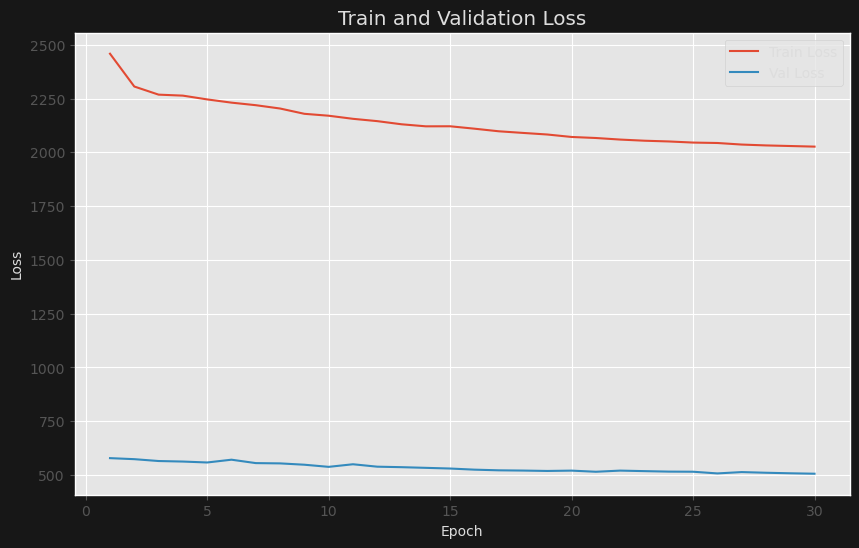

In [8]:
import matplotlib.pyplot as plt

def visualize_losses(train_losses, val_losses, n_epochs):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, n_epochs + 1), val_losses, label='Val Loss')
    plt.legend(labelcolor='black')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()
    plt.show()

# Visualize losses
visualize_losses(train_epoch_losses, val_epoch_losses, train_config['n_epochs'])

1.0 1.0


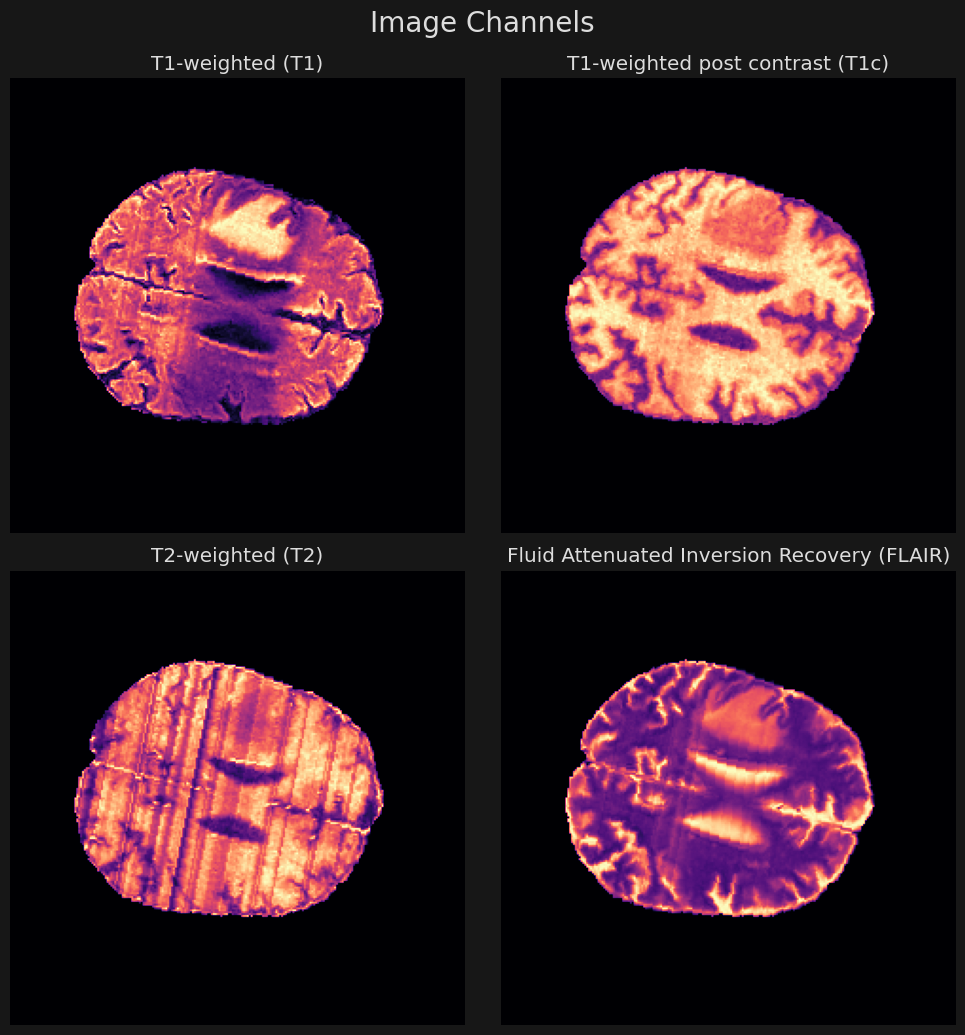

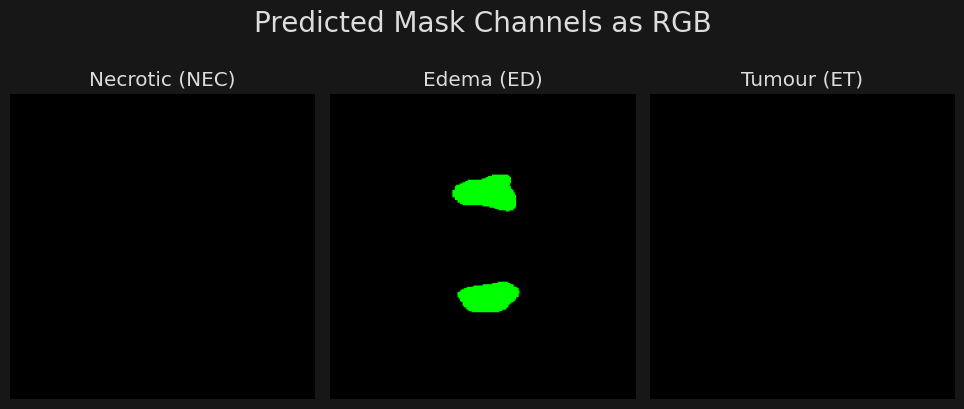

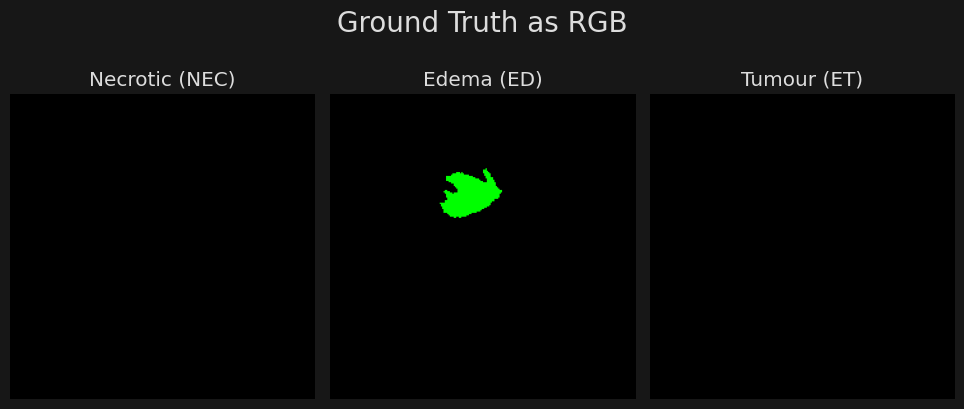

In [7]:
def display_test_sample(model, test_input, test_target, device):
    test_input, test_target = test_input.to(device), test_target.to(device)

    # Obtain the model's prediction
    test_pred = torch.sigmoid(model(test_input))

    # Process the image and masks for visualization
    image = test_input.detach().cpu().numpy().squeeze(0)
    mask_pred = test_pred.detach().cpu().numpy().squeeze(0)
    mask_target = test_target.detach().cpu().numpy().squeeze(0)
    print(mask_pred.max(), mask_target.max())

    # Set the plot aesthetics
    plt.rcParams['figure.facecolor'] = '#171717'
    plt.rcParams['text.color']       = '#DDDDDD'

    # Display the input image, predicted mask, and target mask
    display_image_channels(image)
    display_mask_channels_as_rgb(mask_pred, title='Predicted Mask Channels as RGB')
    display_mask_channels_as_rgb(mask_target, title='Ground Truth as RGB')
    

# Set so model and these images are on the same device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_test = build_resunetplusplus().to(device)
model_test.load_state_dict(torch.load('Resunet++_brain_segmentation_lr-0.0001_all_batches.pth'))
# Get an image from the validation dataset that the model hasn't been trained on
test_input, test_target = next(test_input_iterator)

display_test_sample(model_test, test_input, test_target, device)